In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
#import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [461]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [4]:
# 데이터 불러오기
try:
    past_sales = pd.read_csv('C:/Users/Administrator/Desktop/딥러닝/rossmann.csv')
    store = pd.read_csv('C:/Users/Administrator/Desktop/딥러닝/store.csv')
except:
    past_sales = pd.read_csv('rossmann.csv')
    store = pd.read_csv('store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체


# 결측값 처리
data = data.dropna(axis=0)

# store 이름 제거
data = data.drop(['Store'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)

# 표준화
scaler = StandardScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)

# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

pd.options.display.max_columns = None
print(data.head(3))

/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_22975/1050322261.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  past_sales = pd.read_csv('rossmann.csv')
/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_22975/1050322261.py:47: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)


      Sales  Customers  CompetitionDistance     Month       Day Open Promo  \
0 -0.133481  -0.169168            -0.539198  0.346614  1.740763    1     1   
1 -0.196581  -0.188537            -0.539198  0.346614  1.626967    1     1   
2 -0.258383  -0.238037            -0.539198  0.346614  1.513171    1     1   

  SchoolHoliday  Promo2  StateHoliday_a  StateHoliday_b  StateHoliday_c  \
0             1       0               0               0               0   
1             1       0               0               0               0   
2             1       0               0               0               0   

   StateHoliday_d  StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
0               1            0            0            1            0   
1               1            0            0            1            0   
2               1            0            0            1            0   

   Assortment_a  Assortment_b  Assortment_c  DayOfWeek_1  DayOfWeek_2  \
0             1     

In [463]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values

In [464]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=False)
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

In [465]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)

In [466]:
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))

train_data의 row : 608740, column : 26
test_data의 row : 202913, column : 26
val_data의 row : 202914, column : 26


In [483]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128,input_dim = x_train.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['mean_absolute_error'])

model_path = 'C:/project/rossmann-store-sales'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 30, mode = 'auto')

model.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_272 (Dense)            (None, 128)               3456      
_________________________________________________________________
dropout_205 (Dropout)        (None, 128)               0         
_________________________________________________________________
batch_normalization_205 (Bat (None, 128)               512       
_________________________________________________________________
dense_273 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_206 (Dropout)        (None, 128)               0         
_________________________________________________________________
batch_normalization_206 (Bat (None, 128)               512       
_________________________________________________________________
dense_274 (Dense)            (None, 128)             

In [468]:
early_stopping = EarlyStopping()

start = datetime.datetime.now()

history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    batch_size=64,
                    epochs=5,
)

end = datetime.datetime.now()
time = end-start
print("처리시간 : ", time)

Epoch 1/5
9512/9512 [==============================] - 20s 2ms/step - loss: 0.2187 - mean_absolute_error: 0.3206 - val_loss: 0.1283 - val_mean_absolute_error: 0.2033
Epoch 2/5
9512/9512 [==============================] - 18s 2ms/step - loss: 0.0934 - mean_absolute_error: 0.2252 - val_loss: 0.2310 - val_mean_absolute_error: 0.2021
Epoch 3/5
9512/9512 [==============================] - 18s 2ms/step - loss: 0.0881 - mean_absolute_error: 0.2193 - val_loss: 0.2406 - val_mean_absolute_error: 0.2211
Epoch 4/5
9512/9512 [==============================] - 19s 2ms/step - loss: 0.0851 - mean_absolute_error: 0.2158 - val_loss: 0.2764 - val_mean_absolute_error: 0.2086
Epoch 5/5
9512/9512 [==============================] - 18s 2ms/step - loss: 0.0841 - mean_absolute_error: 0.2146 - val_loss: 0.2584 - val_mean_absolute_error: 0.2050
처리시간 :  0:01:31.864013


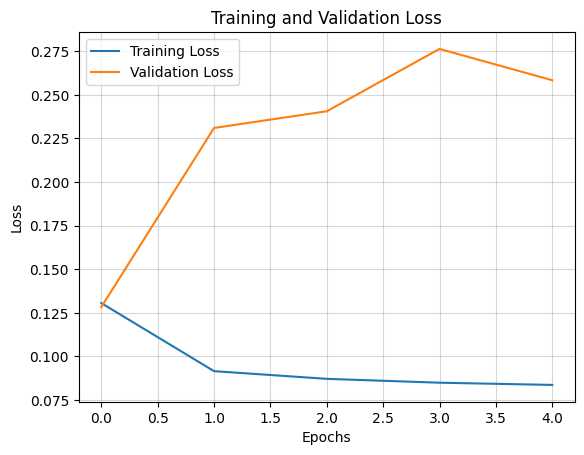

In [470]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그리드 추가
plt.grid(True, linestyle='-', alpha=0.5)

plt.show()


In [510]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = x_train.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
loss='mae',
metrics=['mean_absolute_error'])

model_path = 'C:/project/rossmann-store-sales'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=10, mode='auto')

history = model.fit(x_train, y_train,
validation_data=(x_valid, y_valid),
batch_size=64,
epochs=50,
callbacks=[checkpoint, early_stopping])
print("\n test accuracy: %.4f" %(model.evaluate(x_test, y_test)[1]))

Epoch 1/50
9512/9512 [==============================] - 21s 2ms/step - loss: 0.2986 - mean_absolute_error: 0.2986 - val_loss: 0.1929 - val_mean_absolute_error: 0.1929

Epoch 00001: val_mean_absolute_error improved from inf to 0.19286, saving model to C:/project\rossmann-store-sales
INFO:tensorflow:Assets written to: C:/project\rossmann-store-sales\assets
Epoch 2/50
9512/9512 [==============================] - 20s 2ms/step - loss: 0.2175 - mean_absolute_error: 0.2175 - val_loss: 0.1989 - val_mean_absolute_error: 0.1989

Epoch 00002: val_mean_absolute_error did not improve from 0.19286
Epoch 3/50
9512/9512 [==============================] - 20s 2ms/step - loss: 0.2113 - mean_absolute_error: 0.2113 - val_loss: 0.1935 - val_mean_absolute_error: 0.1935

Epoch 00003: val_mean_absolute_error did not improve from 0.19286
Epoch 4/50
9512/9512 [==============================] - 20s 2ms/step - loss: 0.2086 - mean_absolute_error: 0.2086 - val_loss: 0.1927 - val_mean_absolute_error: 0.1927

Epoch 0

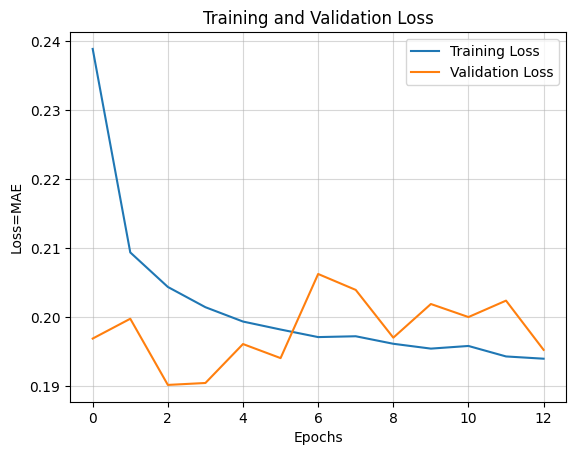

6342/6342 [==============================] - 3s 511us/step - loss: 0.2168 - mean_absolute_error: 0.2168

 test accuracy: 0.2168


In [500]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss=MAE')
plt.legend()

# 그리드 추가
plt.grid(True, linestyle='-', alpha=0.5)

plt.show()
print("\n test accuracy: %.4f" %(model.evaluate(x_test, y_test)[1]))